<a href="https://colab.research.google.com/github/Nitroshades/UTD_Colab/blob/main/decision_tree_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

mush_train= pd.read_csv("mush_train.data",header=None)
print(mush_train.head(10))
mush_train=mush_train.to_numpy()
print(mush_train.shape)

mush_test= pd.read_csv("mush_test.data",header=None)
print(mush_test.head(10))
mush_test=mush_test.to_numpy()
print(mush_test.shape)


  0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0  e  f  f  n  t  n  f  c  b  n  ...  s  p  g  p  w  o  p  n  y  d
1  e  x  y  y  t  a  f  c  b  n  ...  y  w  w  p  w  o  p  n  y  p
2  p  x  y  n  t  p  f  c  n  k  ...  s  w  w  p  w  o  p  k  s  g
3  p  x  s  n  f  y  f  c  n  b  ...  k  w  w  p  w  o  e  w  v  p
4  e  x  f  w  t  l  f  w  n  w  ...  s  w  w  p  w  o  p  u  v  d
5  p  x  s  e  f  f  f  c  n  b  ...  s  w  p  p  w  o  e  w  v  p
6  e  x  y  g  t  n  f  c  b  n  ...  s  p  g  p  w  o  p  k  y  d
7  e  x  s  w  f  n  f  w  b  n  ...  s  w  w  p  w  o  e  k  s  g
8  e  x  s  e  t  n  f  c  b  w  ...  s  w  e  p  w  t  e  w  c  w
9  p  x  f  g  f  c  f  w  n  u  ...  s  w  w  p  w  o  p  k  v  d

[10 rows x 23 columns]
(4712, 23)
  0  1  2  3  4  5  6  7  8  9   ... 13 14 15 16 17 18 19 20 21 22
0  p  x  f  y  f  f  f  c  b  p  ...  k  n  b  p  w  o  l  h  y  g
1  p  x  f  g  f  f  f  c  b  g  ...  k  p  n  p  w  o  l  h  v  p
2  p  x  f  y  f  f  f  c  

In [2]:
X_train = mush_train[:,1:]
Y_train = mush_train[:, 0]
X_test = mush_test[:, 1:]
Y_test = mush_test[:, 0]
print (X_train.shape,Y_train.shape)
print(X_test.shape, Y_test.shape)

(4712, 22) (4712,)
(3412, 22) (3412,)


In [3]:
#constructing decision tree
class Node():
  def __init__(self, X, Y, parent, isInternal = True, branched_at=None):
    self.X = X
    self.Y = Y 
    self.parent = parent
    self.isInternal = isInternal
    self.child = []
    self.IG = 0 
    self.branched_at = branched_at

    if(len(set(Y)) == 1):
      self.leaf = True
      self.label = Y[0]
    else:
      self.leaf = False
      self.label = 'not a leaf'
    
      if((parent == None or isInternal) and (not self.leaf)):
        self.branch()

  def cond_entropy(self, xi):
    H_YXi = 0
    for cat in set(self.X[:,xi]): # pick the column rep the attribute 'xi'
      Y_cat = self.Y[np.where(self.X[:,xi]== cat)]
      e = len(np.where(Y_cat == 'e')[0])/ Y_cat.shape[0]
      p = len(np.where(Y_cat == 'p')[0])/Y_cat.shape[0]
      H_YXi -= (Y_cat.shape[0]/self.Y.shape[0]) * (np.log(e**e)+ np.log(p**p))

    return H_YXi

  def branch(self):
    e = len(np.where(self.Y=='e')[0])/self.Y.shape[0]
    p = len(np.where(self.Y=='p')[0])/self.Y.shape[0]
    H_Y = -(np.log(e**e)+np.log(p**p))

    if(self.branched_at == None):
      max_gain = 0

      for xi in range(self.X.shape[1]):
        H_Yxi = self.cond_entropy(xi)
        IG = H_Y - H_Yxi
        if(IG > max_gain) or (IG == max_gain and self.branched_at < xi):
          max_gain = IG
          self.branched_at = xi
      else:
        max_gain = H_Y = self.cond_entropy(self.branched_at)

      self.IG = max_gain
      self.label = 'IG=' + str(np.round(max_gain, 3)) + '\n at' + str(self.branched_at)

      for cat in set(self.X[:, self.branched_at]):
        X_c = self.X[np.where(self.X[:, self.branched_at] == cat)[0], :]
        Y_c = self.Y[np.where(self.X[:, self.branched_at] == cat)[0]]
        new_mode = Node(X_c, Y_c, self, self.isInternal)
        self.child.append(new_mode)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree(main_node, index, dim):

  def dfs(mnode, pre_index):
    for node in mnode.child:
      index = node.label
      if(index in {'e', 'p'}):
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at]+ '->' + index
      else:
        index = str(mnode.branched_at) + node.X[0, mnode.branched_at]+ '\n' + index

      Graph.add_node(index)
      Graph.add_edge(pre_index, index)
      dfs(node, index)


  Graph = nx.DiGraph()
  Graph.add_node(main_node.label)
  dfs(main_node, index)
  pos = graphviz_layout(Graph, prog='dot')
  plt.figure(figsize=dim)
  nx.draw(Graph, pos, with_labels=True, font_weight='bold', node_color='skyblue', alpha=1, node_size=1600)
  plt.show()

In [5]:
main_node = Node(X_train, Y_train, None)

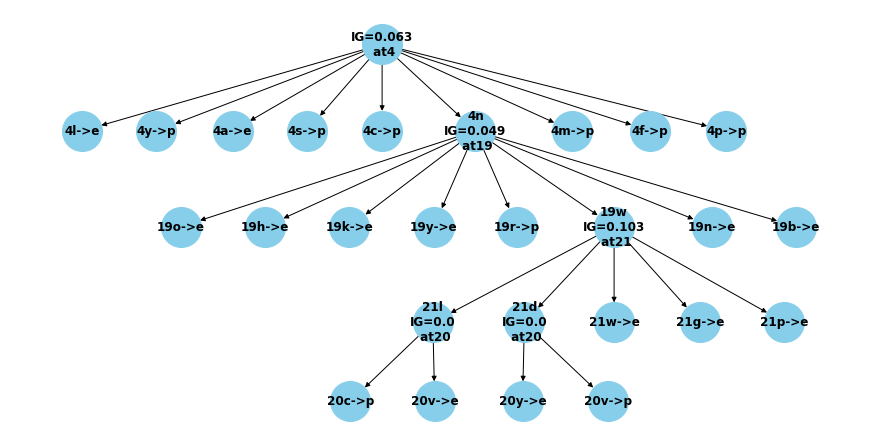

In [6]:
plot_tree(main_node, main_node.label, [12, 6])

In [7]:
def predict(X,main_node):
  Y_pred=[]
  for i in range(X.shape[0]):
    cur_node = main_node

    while True:
     if(cur_node.label in set(Y_train)):
       Y_pred.append(cur_node.label)
       break
     else:
      flag = 0
      for node in cur_node.child:
          check = list(set(node.X[:, cur_node.branched_at]))[0]
          if(X[i,cur_node.branched_at] == check):
            cur_node = node
            flag = 1
            break
      if(flag == 0):
            Y_pred.append('Not found')  
            break
  return Y_pred          

In [8]:
print(predict(X_test[:10, :],main_node))

['p', 'p', 'p', 'e', 'p', 'p', 'p', 'e', 'p', 'e']
